# Optimal Coherent Control

Quantum computers perform computations by executing circuits consisting of a
set of quantum gates, and recording measurement at its output. At this level
of abstraction, quantum gates are well-defined mathematical operations on a
$n$-qubit Hilbert space. In practice, different hardware realizations engineer a
universal set of gates through ia variety of controllable sets of physical interactions between
the qubits. Optimal coherent control (OCC) provides is a framework whereby qubit control
functions can be optimized to produce a desired target quantum gate.


%% a slide [markdown] {"slideshow": {"slide_type": "slide"}}
In this tutorial example, we consider a very simple system made out of only two qubits,
described by the Hamiltonian
$$
H_0 = \sum_{j=1,2}\omega_j a^\dagger_ja_j + g (a^\dagger_1a_2 + a_1 a^\dagger_2)
$$
where $\{\omega_j\}$ are the frequencies of the transmons and $g$ is the qubit exchange
coupling.

### Trotter simulation of quantum dynamics

Before considering the gate optimization, we first need to simulate the dynamics of the system
generate by the Hamiltonian $H$. We begin by importing the relevant packages and
setting up the simulation parameters:

In [1]:
using Random
using ITensors
using PastaQ
using Observers
using DataFrames
using Plots

GHz = 2π
MHz = 1e-3 * GHz
plot_args = (dpi=1000,size=(600,300), margin=5Plots.mm, marker = :circle, markersize = 2,linewidth = 1)

n  = 2            # number of qubits
g  = 12 * MHz     # exchange interaction
ω₁ = 5.0 * GHz    # qubit-1 frequency
ω₂ = 5.0 * GHz    # qubit-2 frequency
ω⃗ = [ω₁, ω₂]

q₁, q₂ = 1, 2         # modes ordering
modes = ["q₁", "q₂"]  # modes labels

#generate the Hilbert space
hilbert = qubits(n)

2-element Vector{ITensors.Index{Int64}}:
 (dim=2|id=525|"Qubit,Site,n=1")
 (dim=2|id=200|"Qubit,Site,n=2")

Now that we have created the Hilbert space and set the parameters, we
can define the Hamiltonian. For now, we define it as a `Vector` of `Tuple`,
where each `Tuple` represent a term in the Hamiltonian. This would be normally
defined as an ITensor object (`OpSum`), but that is not yet fully differentiable.

In [2]:
function hamiltonian(ω⃗::Vector, g::Number)
  H = Tuple[]
  ω₁, ω₂ = ω⃗
  H = vcat(H, [(ω₁, "a† * a", q₁)])
  H = vcat(H, [(ω₂, "a† * a", q₂)])
  H = vcat(H, [(g,  "a†a + aa†", (q₁, q₂))])
  return H
end

H = hamiltonian(ω⃗, g)

3-element Vector{Tuple}:
 (31.41592653589793, "a† * a", 1)
 (31.41592653589793, "a† * a", 2)
 (0.07539822368615504, "a†a + aa†", (1, 2))

We would like to simulate the system dynamics and record measurements, such
as the average mode occupation. We use the `Observers.jl` package to keep
track of observables. The `Observer` object is a container of a set of `Function`,
which are called iteratively inside whatever iterative loop we consider.
We also need to add a `Function` that measure the average occupation here.

In [3]:
function population(ψ::MPS, site::Int)
  s = siteinds(ψ)[site]
  orthogonalize!(ψ, site)
  norm2_ψ = norm(ψ)^2
  val = scalar(ψ[site] * op("a† * a", s) * dag(prime(ψ[site], s))) / norm2_ψ
  return real(val)
end;

#define a vector of observables and create the `Observer`.
observables = ["n($α)" => x -> population(x, k)  # actually x -> expect(x, "a† * a"; sites = k)
               for (k,α) in enumerate(modes)]
obs = observer(observables)

Observers.Observer with 2 entries:
  "n(q₁)" => NamedTuple{(:f, :results), Tuple{Union{Nothing, Function}, Any}}((…
  "n(q₂)" => NamedTuple{(:f, :results), Tuple{Union{Nothing, Function}, Any}}((…

We are not ready to simulate the system dynamics using a Trotter expansion.
The time-evolution propagator up to time $t$ is decomposed as
$$
U(t) = U(\delta t)^M
$$
with $t_g = M\delta t$ being the finla time. Each elementary propagator is
then approximated with its Trotter expansion (to order 2 by default):
$$
U(\delta t) \approx U_K(\delta t)\dots U_2(\delta t) U_1(\delta t)
$$

In [4]:
tg = 30                  # final time (in ns)
trottersteps = 100       # number of Trotter steps
δt = tg / trottersteps   # step size
ts = 0.0:δt:tg           # time list

#build the Trotter circuit
circuit = trottercircuit(H; ts = ts, layered = true)

#set initial state |ψ⟩ = |1,0⟩
ψ₀ = productstate(hilbert, [1,0])

#perform TEBD simulation and generate output `MPS`
ψ = runcircuit(ψ₀, circuit; (observer!) = obs,
               move_sites_back_before_measurements = true, outputlevel = 0)

ITensors.MPS
[1] ((dim=2|id=525|"Qubit,Site,n=1"), (dim=2|id=692|"Link,n=1"))
[2] ((dim=2|id=200|"Qubit,Site,n=2"), (dim=2|id=692|"Link,n=1"))


The measurements taken during the dynamics (one at each Trotter layer) are
store in the Observer and can be retrieved into a `DataFrame` format (for example).
We plot here the average occupation of the two modes as a function of time:

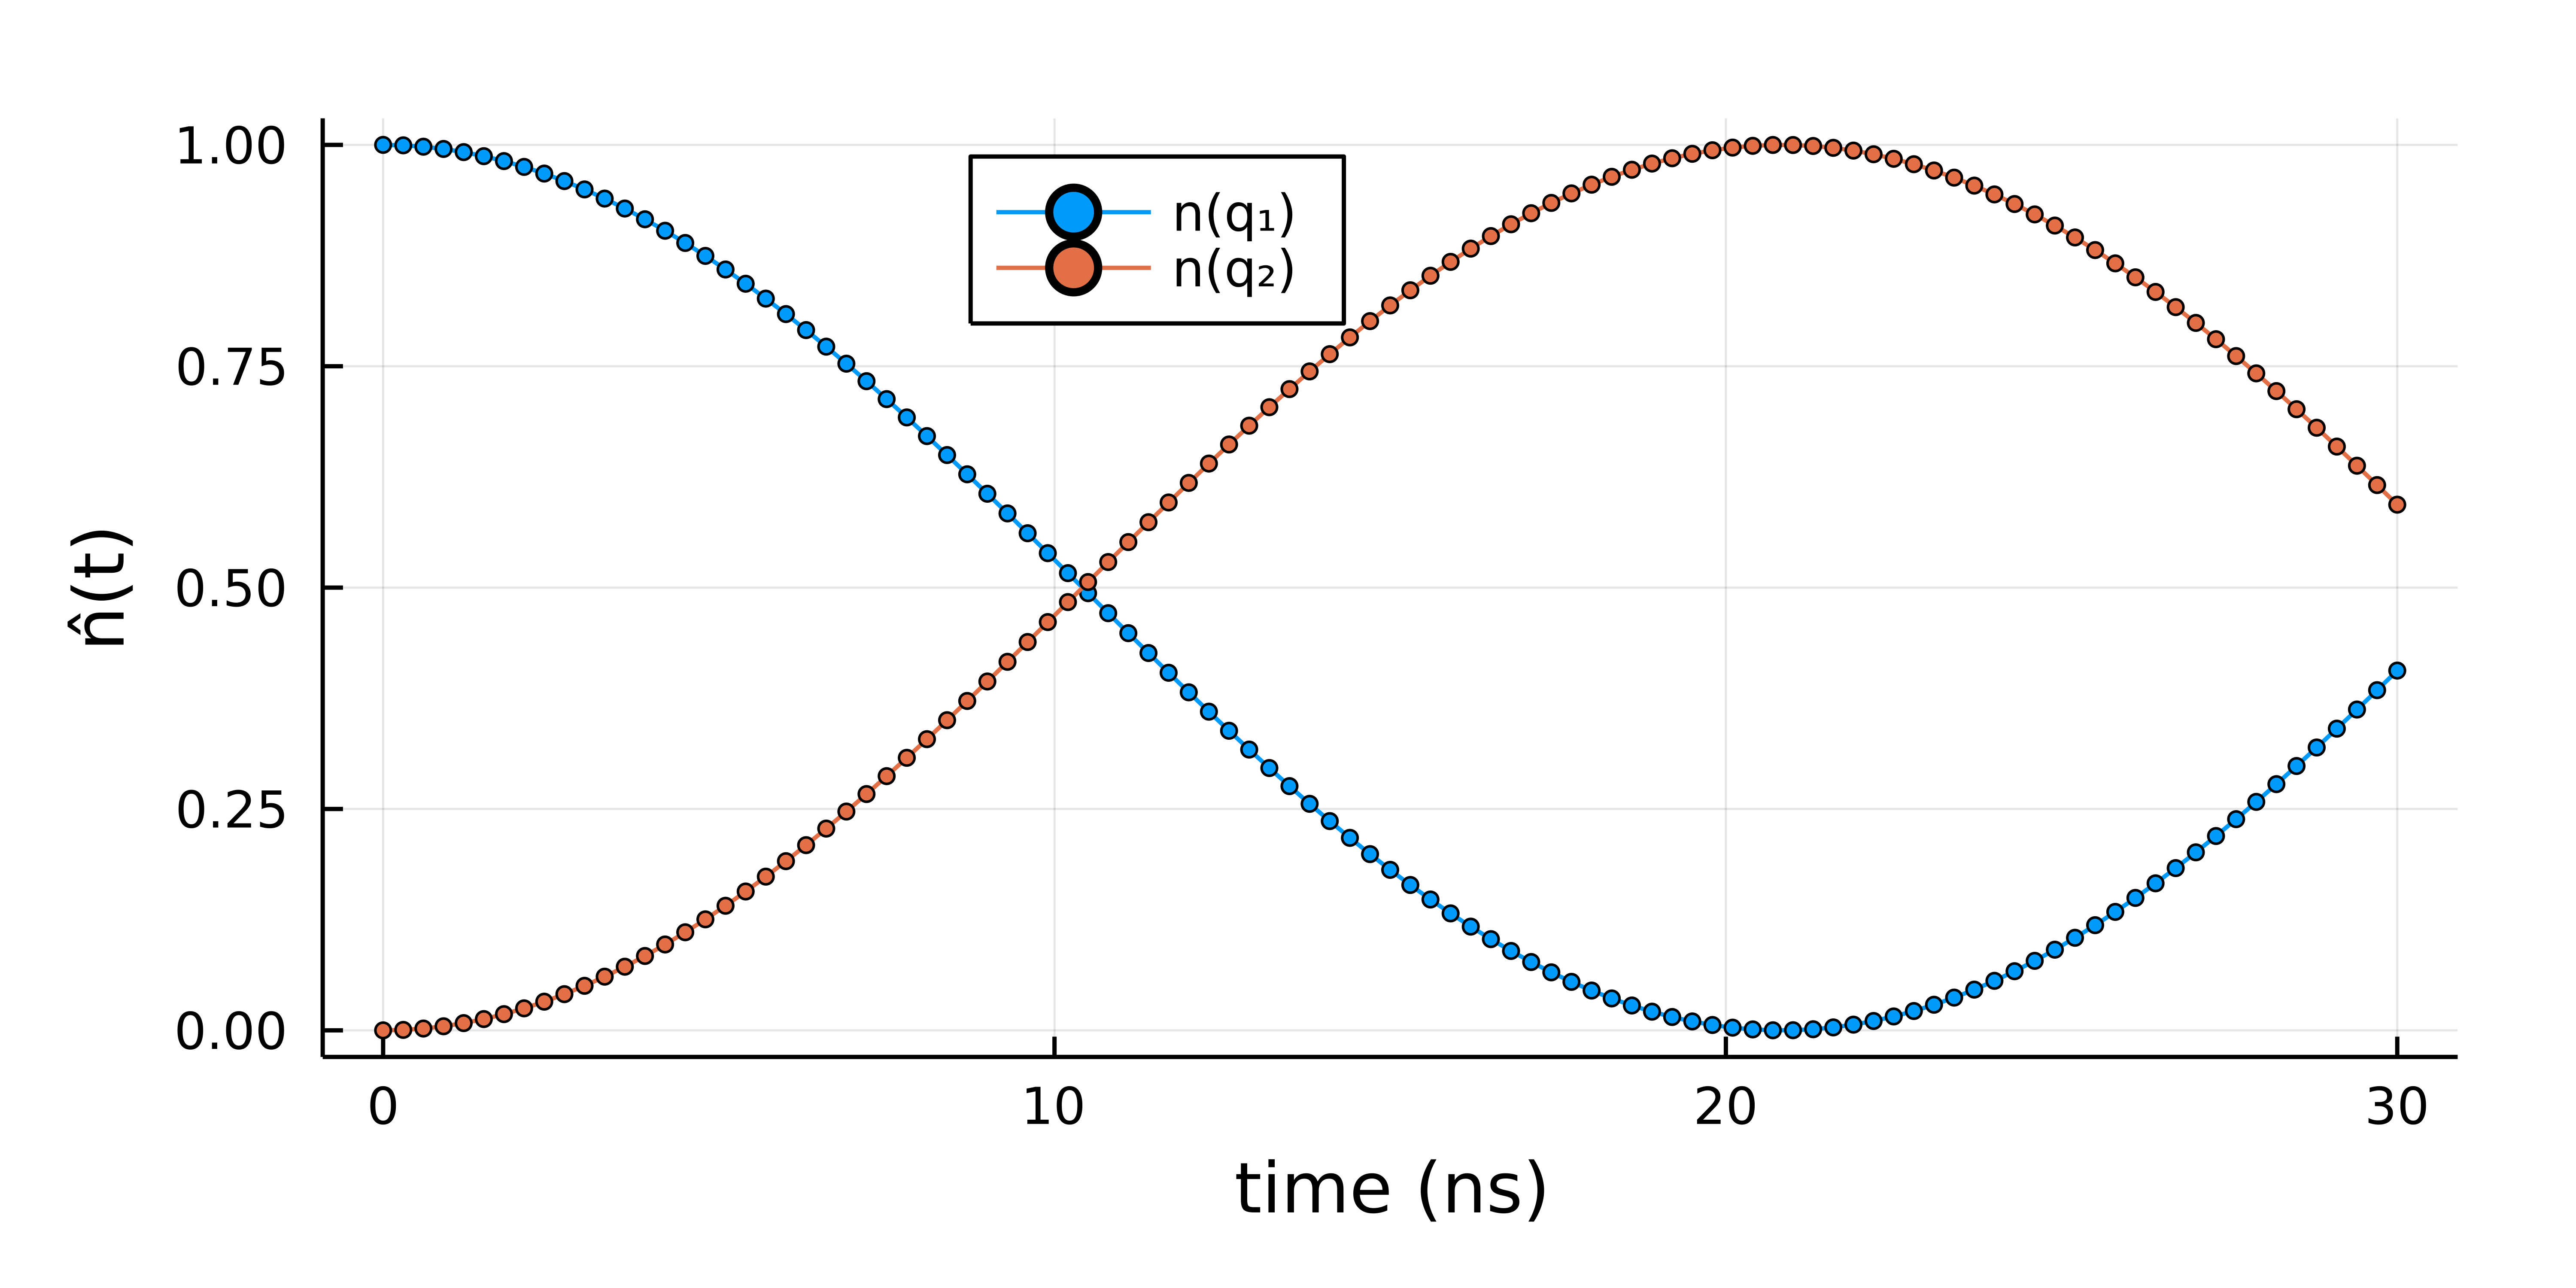

In [5]:
p = plot(xlabel = "time (ns)", ylabel = "n̂(t)", legend = (0.40,0.9); plot_args...)
p = plot!(p, ts, obs[!,"n(q₁)"], label = "n(q₁)";  plot_args...)
p = plot!(p, ts, obs[!,"n(q₂)"], label = "n(q₂)";  plot_args...)
p

In this simulation we placed the two qubits on resonance ($\omega_1=\omega_2$).
By populating one of the qubit with an excitation (qubit 1 above), we observe that
the dynamics swaps the excitation between the two qubits at time. In fact, this system
implements a perfect iSwap gate.

In practice, in idle mode the two qubits are placed at some detuning, and placed on resonance
only when realizing the gate. Here we consider this setting, and we will optimize the modulation
of the two qubit frequencies to realize the gate when starting further apart. But first let's just
re-run the previous dynamical simulation in this setup:

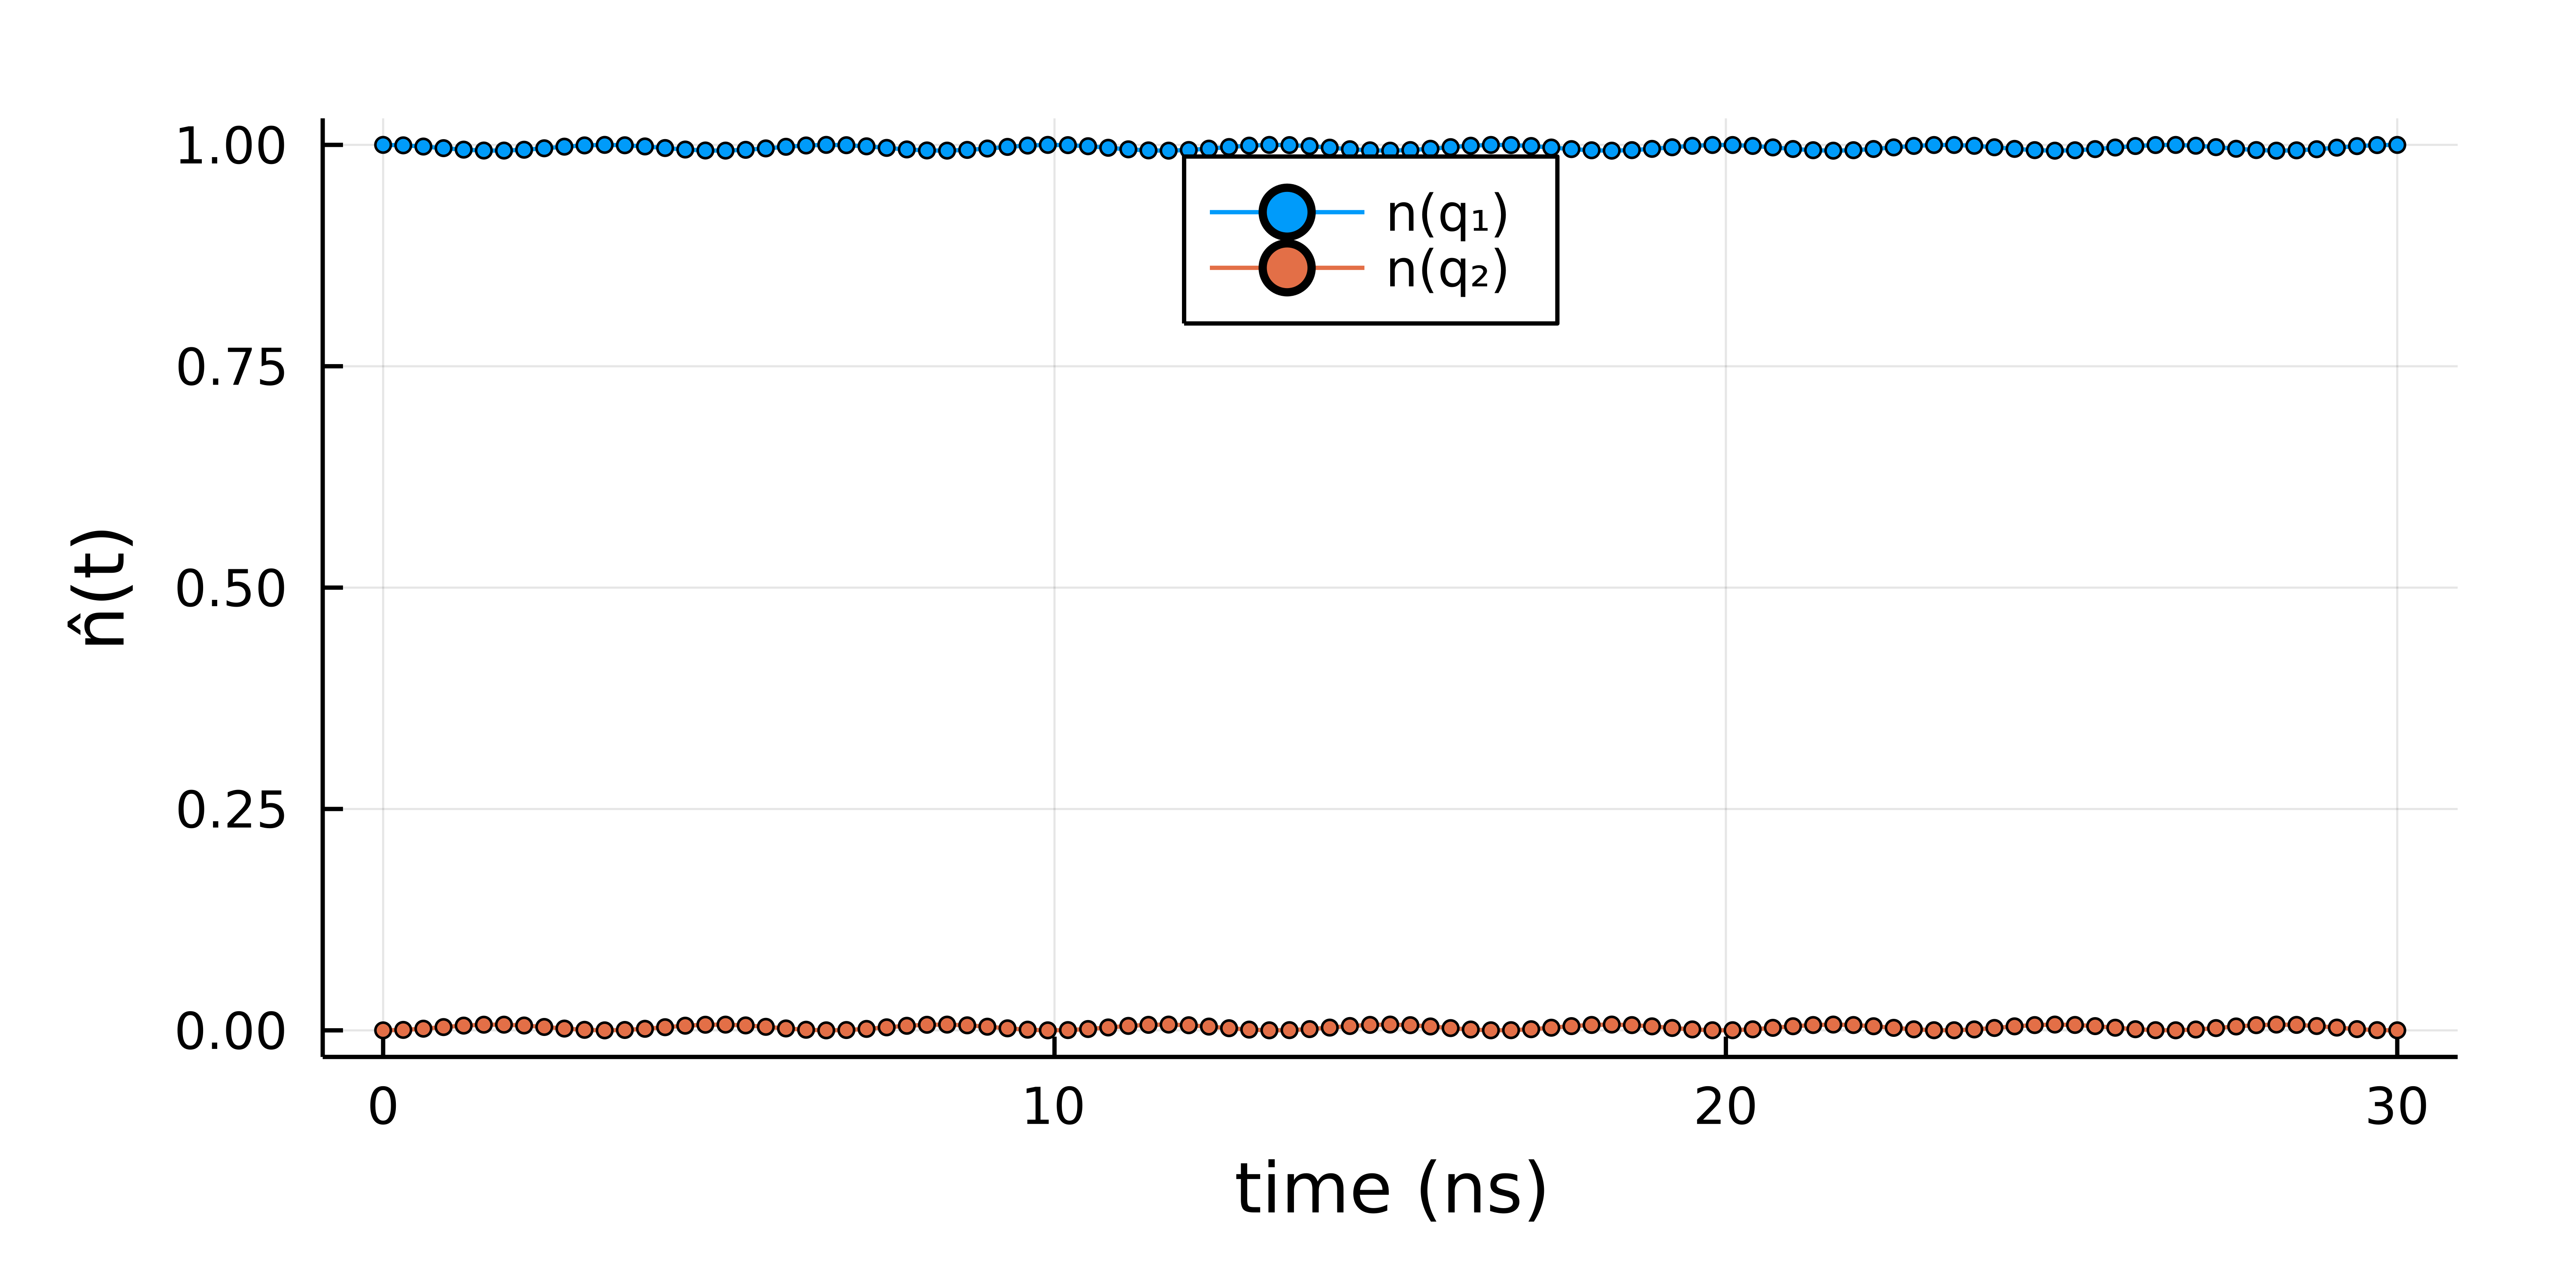

In [6]:
ω₁ = 5.0 * GHz
ω₂ = 5.3 * GHz
ω⃗ = [ω₁, ω₂]

H = hamiltonian(ω⃗, g)

obs = observer(observables)

circuit = trottercircuit(H; ts = ts, layered = true)

ψ₀ = productstate(hilbert, [1,0])

ψ = runcircuit(ψ₀, circuit; (observer!) = obs,
               move_sites_back_before_measurements = true, outputlevel = 0)

p = plot(xlabel = "time (ns)", ylabel = "n̂(t)", legend = (0.50,0.9); plot_args...)
p = plot!(p, ts, obs[!,"n(q₁)"], label = "n(q₁)";  plot_args...)
p = plot!(p, ts, obs[!,"n(q₂)"], label = "n(q₂)";  plot_args...)
p

### Control optimization
After importing relevant packages for the optimization, we now fix the desired
gate time to `t_g=25$ns. We also define two control functions:
$$
f_{fourier}(\theta, t) = \Lambda \tanh(\sum_i\theta_i \sin(\pi i t /t_g))
$$
and
$$
f_{pulse}(\theta, t) = \tanh((t - t_{on})/\gamma) - \tanh((t - t_{off})/\gamma)
$$

In [7]:
using Zygote
using OptimKit
using StatsBase: mean

tg = 25
trottersteps = 100
δt = tg / trottersteps
ts = 0.0:δt:tg

Λ = 20.0 * MHz
fourier_control(ϑ, t) =
  Λ * tanh(sum([ϑ[i] * sin(π * i * t / tg) for i in 1:length(ϑ)]))

function pulse_control(ϑ, t)
  y₀, ypulse, ton, toff, γ = ϑ
  f = tanh((t - ton)/γ) - tanh((t - toff)/γ)
  return y₀ + 0.5 * (ypulse - y₀) * f
end

pulse_control (generic function with 1 method)

We define the new Hamiltonian as follows. We take qubit 2 and send a pulse
to bring its frequency near $\omega_1$. At the same time, we also introduce
a frequency modulation $\omega_1(t)$ with small amplitude.

In [8]:
function hamiltonian(θ⃗::Vector, ω⃗::Vector, g::Number, t::Float64)
  ω₁, ω₂ = ω⃗
  ϑ₁, ϑ₂ = θ⃗
  H = Tuple[]
  H = vcat(H, [(ω₁ + fourier_control(ϑ₁, t), "a† * a", q₁)])
  H = vcat(H, [(ω₂ + pulse_control(ϑ₂, t), "a† * a", q₂)])
  H = vcat(H, [(g,   "a†a + aa†", (q₁, q₂))])
  return H
end

hamiltonian(θ::Vector, t::Float64) = hamiltonian(θ, ω⃗, g, t);

Let's see how this look like:

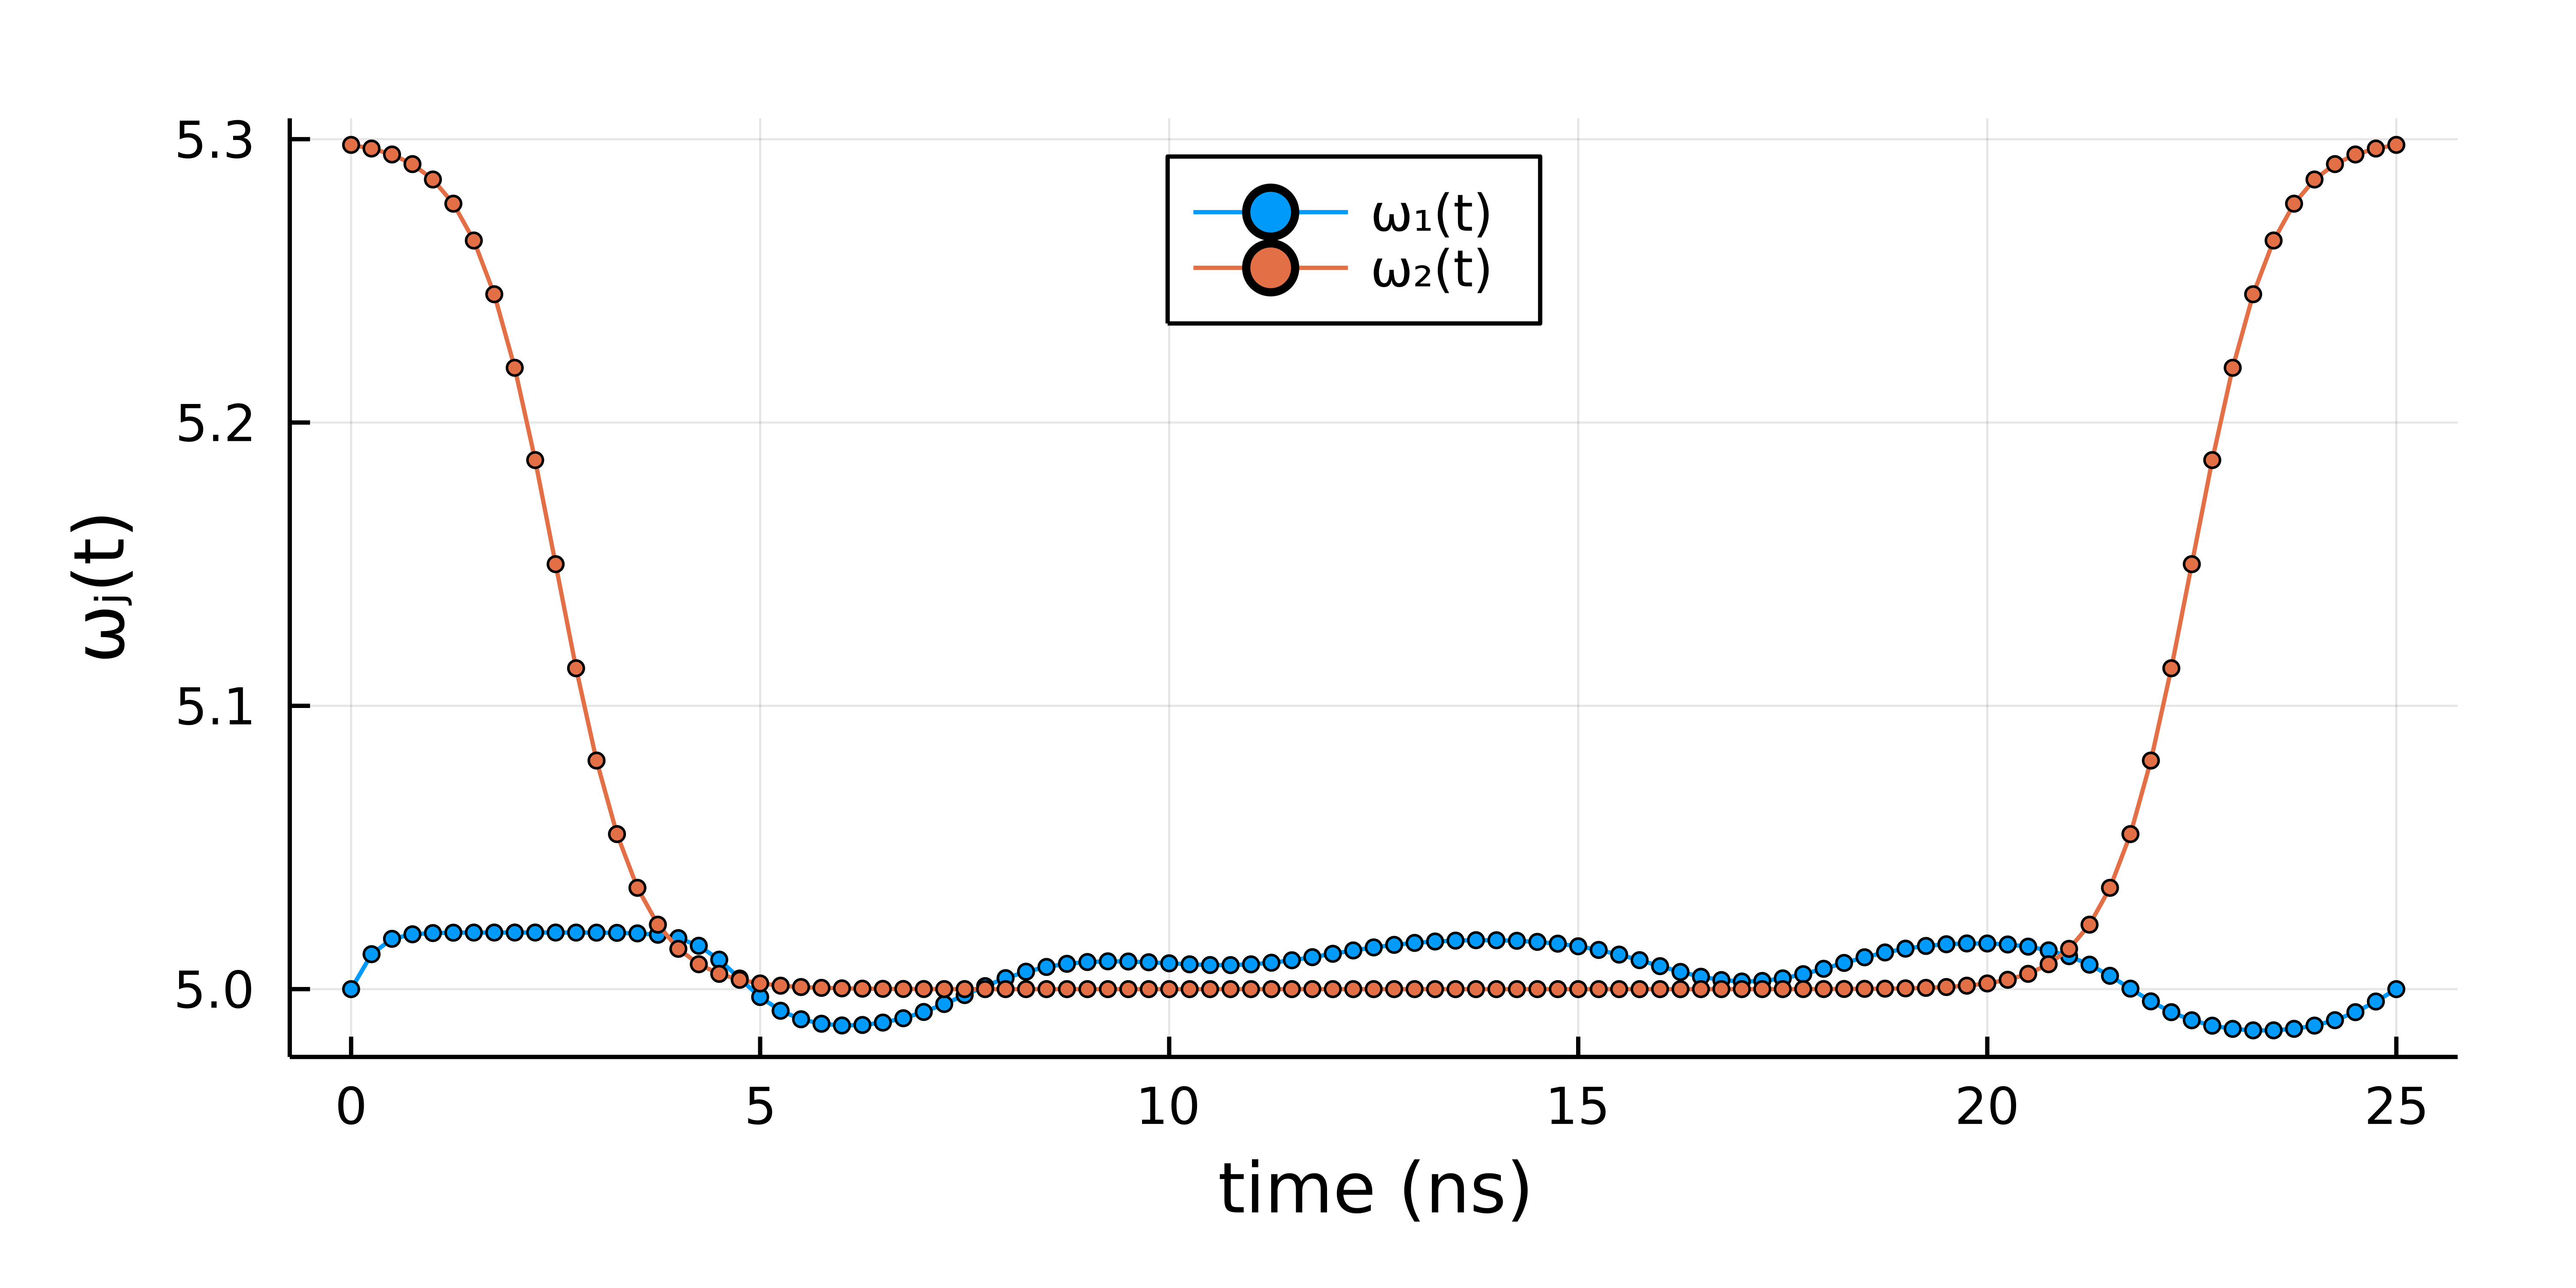

In [9]:
Random.seed!(12345)
Ntones = 8
ϑ₁ = rand(Ntones)
ϑ₂ = [0.0, ω₁ - ω₂, 0.1 * tg, 0.9 * tg, 1]
θ⃗₀ = [ϑ₁, ϑ₂]
p = plot(xlabel = "time (ns)", ylabel = "ωⱼ(t)", title = "", legend = (0.50,0.9); plot_args...)
p = plot!(p, ts, [ω₁ + fourier_control(ϑ₁, t) for t in ts] ./ GHz; label = "ω₁(t)", plot_args...)
p = plot!(p, ts, [ω₂ + pulse_control(ϑ₂, t) for t in ts] ./ GHz; label = "ω₂(t)", plot_args...)
p

The cost function to our optimization is computed from the inner products between
the time-evolved and the desired wavefunctions:
$$
C(\theta) = 1 - \frac{1}{D^2}\bigg| \sum_i\langle\phi_i|U|\psi_i\rangle\bigg|^2
$$

In [10]:
function loss(Ψ⃗, Φ⃗, θ⃗)
  #build sequence Tuple (OpSum) Hamiltonians at different times
  Ht = [hamiltonian(θ⃗, t) for t in ts]
  #Trotter-Suzuki decomposition
  circuit = trottercircuit(Ht; ts = ts)
  #run the circuit
  UΨ⃗ = [runcircuit(ψ, circuit; cutoff = 1e-7) for ψ in Ψ⃗]
  #compute inner product ⟨ϕ|ψ(t)⟩
  ip = [inner(ϕ,ψ) for (ϕ,ψ) in zip(Φ⃗, UΨ⃗)]
  return 1 - abs2(mean(ip))
end;

We not set the ideal gate (Lazy format) and define loss closure.

In [11]:
ideal_gate = [
  [0,0] => (1,   [0,0]),
  [1,0] => (-im, [0,1]),
  [0,1] => (-im, [1,0]),
  [1,1] => (1,   [1,1])
]

Ψ⃗ = [productstate(hilbert, σ) for σ in first.(ideal_gate)]
Φ⃗  = [ϕ * productstate(hilbert, σ) for (ϕ, σ) in last.(ideal_gate)];
loss(θ) = loss(Ψ⃗, Φ⃗, θ)

loss (generic function with 2 methods)

We initialize the optimizer the run the optimization for $20`` steps:

In [12]:
optimizer = LBFGS(verbosity = 2, maxiter = 20)
loss_n_grad(x) = (loss(x), convert(Vector, loss'(x)))
θ⃗, fs, gs, niter, normgradhistory = optimize(loss_n_grad, θ⃗₀, optimizer)
normgradhistory[:,1]

[ Info: LBFGS: initializing with f = 0.428027702152, ‖∇f‖ = 7.1391e+00
[ Info: LBFGS: iter    1: f = 0.081706703307, ‖∇f‖ = 1.0920e+00, α = 8.88e-02, m = 0, nfg = 5
[ Info: LBFGS: iter    2: f = 0.075630625130, ‖∇f‖ = 6.2026e-01, α = 1.00e+00, m = 1, nfg = 1
[ Info: LBFGS: iter    3: f = 0.018985770742, ‖∇f‖ = 5.3655e-01, α = 3.39e+01, m = 2, nfg = 5
[ Info: LBFGS: iter    4: f = 0.017343386295, ‖∇f‖ = 6.2424e-02, α = 1.00e+00, m = 3, nfg = 1
[ Info: LBFGS: iter    5: f = 0.017254135251, ‖∇f‖ = 9.0683e-02, α = 1.00e+00, m = 4, nfg = 1
[ Info: LBFGS: iter    6: f = 0.016900915853, ‖∇f‖ = 1.6028e-01, α = 1.00e+00, m = 5, nfg = 1
[ Info: LBFGS: iter    7: f = 0.016684544856, ‖∇f‖ = 1.1751e-01, α = 1.00e+00, m = 6, nfg = 1
[ Info: LBFGS: iter    8: f = 0.016551583413, ‖∇f‖ = 3.8888e-02, α = 1.00e+00, m = 7, nfg = 1
[ Info: LBFGS: iter    9: f = 0.016479518312, ‖∇f‖ = 6.4269e-02, α = 1.00e+00, m = 8, nfg = 1
[ Info: LBFGS: iter   10: f = 0.016410592360, ‖∇f‖ = 1.1813e-01, α = 1.00e+00, m = 

21-element Vector{Float64}:
 0.42802770215205654
 0.08170670330731655
 0.07563062512952556
 0.01898577074238339
 0.01734338629510168
 0.01725413525060271
 0.016900915853150456
 0.016684544855658068
 0.016551583412741544
 0.01647951831244654
 ⋮
 0.015693717081292746
 0.014301615529791145
 0.009782604090223024
 0.0027689009436382417
 0.002078887810308072
 0.0017573259080719827
 0.0015658790481211105
 0.0014944843795936524
 0.001304054320584891

In markdown sections we can use markdown syntax. For example, we can

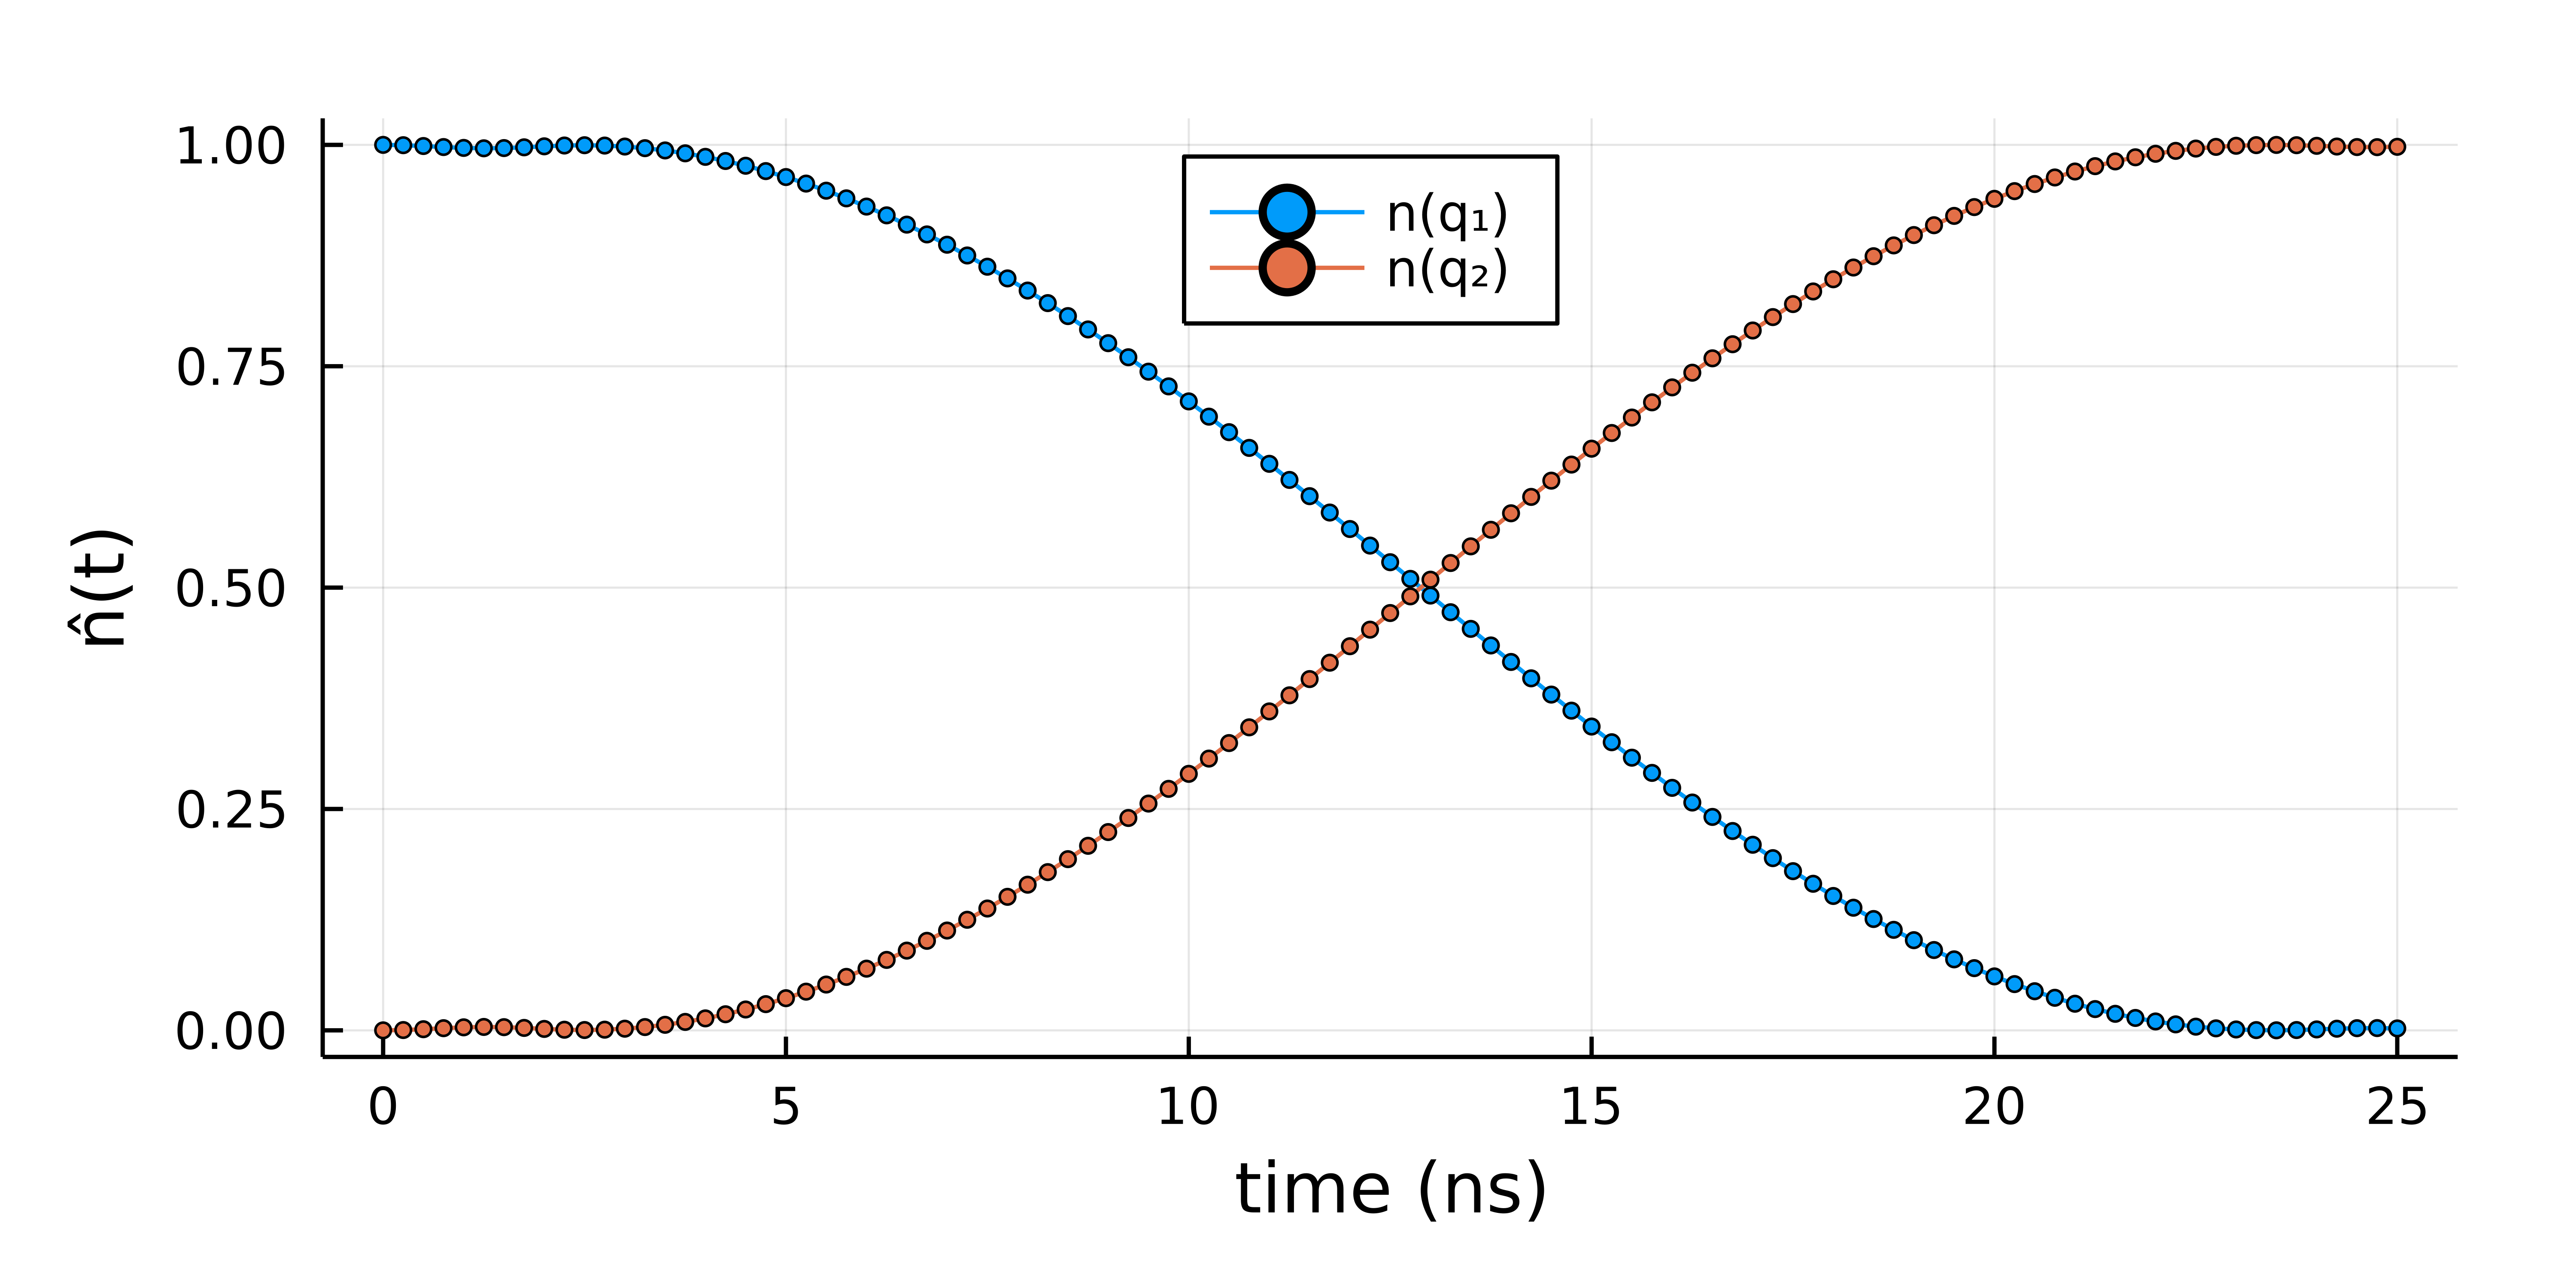

In [13]:
Ht = [hamiltonian(θ⃗, t) for t in ts]
circuit = trottercircuit(Ht; ts = ts, layered = true)
ψ₀ = productstate(hilbert, [1,0])
observables = ["n($α)" => x -> population(x, k)
               for (k,α) in enumerate(modes)]
obs = observer(observables)
ψ = runcircuit(ψ₀, circuit; (observer!) = obs,
               move_sites_back_before_measurements = true, outputlevel = 0)
p = plot(xlabel = "time (ns)", ylabel = "n̂(t)", legend = (0.50,0.9); plot_args...)
p = plot!(p, ts, obs[!,"n(q₁)"], label = "n(q₁)";  plot_args...)
p = plot!(p, ts, obs[!,"n(q₂)"], label = "n(q₂)";  plot_args...)
p

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*